In [2]:
import sqlglot
import pandas as pd
import numpy as np
from sqlglot import Dialect
import sqlglot.dialects
from sqlglot.expressions import Func
from sqlglot.generator import Generator
from sqlglot.parser import Parser
from sklearn.cluster import KMeans
from sqlglot.tokens import Tokenizer
from ml import MachineLearning
from visualizations import Visualization

class ClusterKMeans(Func):
    
    
    is_var_len_args = True


    @property
    def sql_name(self):
        # Force the function name to be "CLUSTER"
        return "CLUSTER"
    
    def execute(self, df, column_name):
        if column_name not in df.columns:
            raise ValueError(f"A coluna '{column_name}' não foi encontrada no DataFrame.")

        data = df[column_name].values.reshape(-1, 1)
        mlclass = MachineLearning()

        kmeans = mlclass.cluster_kmeans(data, n_clusters=3)
        df["cluster"] = kmeans
        return df

    def to_cte(self, df, alias="resultados_cluster"):
        
        return self.execute(df, self.this[0].name)

class Scatter(Func):
    arg_count = 1

    def execute(self, x, y):
        vis = Visualization()
        vis.scatter(x,y)
        return True


    def to_cte(self, x,y):
        return self.execute(x,y)


class CustomDialect(Dialect):
    class Tokenizer(Tokenizer):
        KEYWORDS = {
            **Tokenizer.KEYWORDS,
            
        }

    class Parser(Parser):
        FUNCTIONS = {**Parser.FUNCTIONS, "CLUSTER": ClusterKMeans.from_arg_list, "SCATTER": Scatter.from_arg_list}


    class Generator(Generator):
        TRANSFORMS = {
            **Generator.TRANSFORMS,
            ClusterKMeans: lambda self, expr: f"CLUSTER({self.sql(expr.this)})",
            Scatter: lambda self, expr: f"SCATTER({self.sql(expr.this)})",
        }

df = pd.DataFrame({
    "id": range(1, 10),
    "price": [10, 20, 30, 200, 220, 250, 1000, 1100, 1200]
})

query = """
WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
SELECT SCATTER(price) FROM resultados_cluster;
"""

# expression = sqlglot.parse_one(query, dialect=CustomDialect)

from sqlglot.executor import execute

execute(query, tables=df)


cluster_expr = expression.find(ClusterKMeans)

df_clusterizado = cluster_expr.to_cte(df)

scatter_expr = expression.find(Scatter)

scatter = scatter_expr.to_cte(df_clusterizado['id'],df_clusterizado['cluster'])

print(df_clusterizado)


ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

   id  price  cluster
0   1     10        2
1   2     20        2
2   3     30        2
3   4    200        0
4   5    220        0
5   6    250        0
6   7   1000        1
7   8   1100        1
8   9   1200        1


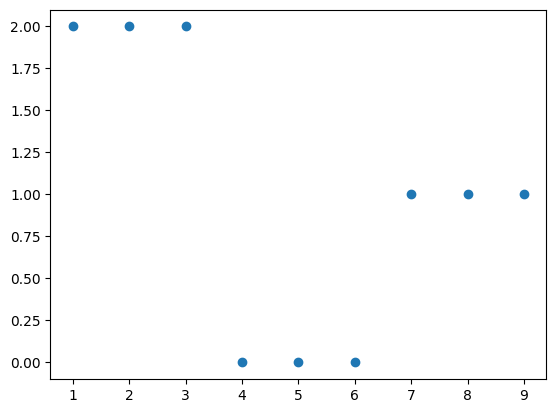

In [162]:
# Base script r
df = pd.DataFrame({
    "id": range(1, 10),
    "price": [10, 20, 30, 200, 220, 250, 1000, 1100, 1200],
})

query = """
WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
SELECT SCATTER(price) FROM resultados_cluster;
"""

expression = sqlglot.parse_one(query, dialect=CustomDialect)


cluster_expr = expression.find(ClusterKMeans)

df_clusterizado = cluster_expr.to_cte(df)

scatter_expr = expression.find(Scatter)

scatter = scatter_expr.to_cte(df_clusterizado['id'],df_clusterizado['cluster'])

print(df_clusterizado)


In [163]:
# Retrieving table data
import psycopg2
from sqlglot.optimizer.scope import build_scope
from collections import defaultdict

ast = sqlglot.parse_one(query, dialect=CustomDialect)
root = build_scope(ast)
dbDict = defaultdict(list)

for index,scope in enumerate(root.traverse()):
    tableName = str(scope.tables[0])
    columnUsed = str(scope.columns[0]) 
    dbDict[tableName].append(columnUsed)
    
dbDict['content'].append('title')
DATAFRAMES = dict()

def execute_query(query):
    conn = psycopg2.connect(
        dbname="postgres",
        user="postgres",
        password="password",
        host="localhost",
        port="5432"
    )
    cursor = conn.cursor()
    cursor.execute(query)
    rows = cursor.fetchall()
    columns = [desc[0] for desc in cursor.description]
    cursor.close()
    conn.close()
    return pd.DataFrame(rows, columns=columns)


def fromDbToDf(schema):
    string = f"SELECT {", ".join(dbDict[schema])} FROM {schema};"
    # Run query to any source (wrapper to any db)
    df = execute_query(string)
    # transform into dataframe and append into dataframes
    DATAFRAMES[schema] = df

    return True


fromDbToDf('content')
DATAFRAMES['content']

,title
0,‘Beautiful And Sad At The Same Time’: Ukrainia...
1,Biden Says Queen's Death Left 'Giant Hole' For...
2,Bill To Help Afghans Who Escaped Taliban Faces...
3,Mark Meadows Complies With Justice Dept. Subpo...
4,Democrats Nominate Seth Magaziner In Key Rhode...
...,...
31971,Jon Stewart Made Elizabeth Warren Puke
31972,Why Chris Christie Should NOT Be President
31973,GOP's Old Ploy: Tag President Obama as the Rac...
31974,Lawmakers Introduce Bill To Tackle Misleadingl...


In [182]:

# query = """
# WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
# SELECT SCATTER(price) as plot FROM resultados_cluster;
# """

# Issoa aqui serve para pegar os args e passar para a função propriamente dita, ou seja, realmente funcione

query = "SELECT CLUSTER(price, 3, 'static') from resultados_cluster"


ast = sqlglot.parse_one(query, dialect=CustomDialect)
# ast.args
# Check when its alias
listaargs = ast.args.get("expressions",[])[0].this
print(type(ast.args.get("expressions",[])))
# listaargs[0].this.this
lista = [x.name for x in listaargs]
className = ast.args.get("expressions",[])[0].__class__.__name__



def teste(a,b,c):
    print(a)

# listOfFunctions = {"ClusterKMeans":ClusterKMeans().execute}
# listOfFunctions["ClusterKMeans"](1,2)

teste(*lista)


<class 'list'>
price


In [ ]:
# Parsing the tree

query = """
WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
SELECT SCATTER(price) as  FROM resultados_cluster;
"""

ast = sqlglot.parse_one(query, dialect=CustomDialect)
# ast.args
ast.args.get("expressions",[])[0].args['this']

udf_registry = {}

def processSelectStatements(expr):
    # This function will iterate over Select expressions

    for expression in expr:
        name = expression.__class__.__name__

        # Check if is an alias
        if name == "Alias":
            expression = expression.this
        
        # I do not need to check for everythign else (such as only columns and etc because this will get recognized by the sql engine)
        if name not in udf_registry:
            print("erro")

        argsList = [expression.this.name for expression.this in expression]

        udf_registry[name].execute(*argsList)
        # Vai passar tudo em String, então teria que converter, pegar as coisas que for dos DF e etc
        
        


    # Process the SELECT expressions.
    # We'll iterate over expressions in the SELECT clause.
    select_expressions = ast.args.get("expressions", [])
    # For this example, we assume that each expression is either a column reference
    # or a function call (our custom UDF).
    for expr in select_expressions:
        # Check if the expression is a function call
        if expr.token_type == sqlglot.exp.Func:  # Or check expr.__class__.__name__
            udf_name = expr.name.upper()  # e.g., "CLUSTER"
            if udf_name in UDF_REGISTRY:
                # Assume the UDF takes the data and one column argument.
                # Extract the first argument’s column name.
                udf_arg = expr.args[0].this  # e.g., "price"
                # Apply the UDF and update the DataFrame.
                data = UDF_REGISTRY[udf_name](data, udf_arg)
        # Otherwise, if it's a plain column reference, we assume the data already has that column.
        # (In a full implementation, you’d construct a new DataFrame with only the requested columns.)

    # Finally, if the query is a SELECT that lists specific columns,
    # extract those columns from the DataFrame.
    # In our example, the main SELECT lists "id" and "priceCluster".
    # You can extract them like this:
    selected_columns = [expr.this for expr in select_expressions if hasattr(expr, 'this')]
    if selected_columns:
        # Normalize column names to lower-case if necessary
        selected_columns = [col.lower() for col in selected_columns]
        data = data[selected_columns]



ParseError: Invalid expression / Unexpected token. Line 3, Col: 49.
  
WITH resultados_cluster AS (SELECT CLUSTER(price) FROM df)  
SELECT SCATTER(price) as  FROM [4mresultados_cluster[0m;


In [70]:
registry = {"CLUSTER":ClusterKMeans}
registry["CLUSTER"].execute()

TypeError: ClusterKMeans.execute() missing 3 required positional arguments: 'self', 'df', and 'column_name'